# Throughput estimation

In this notebook, we evaluate the efficacy of the throughput estimator.

## Import statements

In [1]:
from plotting_utils import *

## Get list of relevant logfiles

In [2]:
from utils import get_logfile_paths_helper

def get_logfile_paths(directory_name):
    import re

    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)\/(.*)\/'
             'profiling_percentage=(\d+\.\d+)\/'
             'num_reference_models=(\d+)\/'
             'seed=(\d+)\/lambda=(\d+\.\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        profiling_percentage = float(m.group(5))
        num_reference_models = int(m.group(6))
        seed = int(m.group(7))
        l = float(m.group(8))
        logfile_paths.append((v100s, p100s, k80s, policy,
                              profiling_percentage,
                              num_reference_models,
                              seed,
                              l, logfile_path))
    return logfile_paths

In [3]:
all_completion_algos = ["PMF"]
all_seeds = set([0, 1, 2])
all_policies = ['max_min_fairness_perf', 'max_min_fairness_packed']
logfile_paths = sorted(get_logfile_paths(
    "/future/u/deepakn/gavel/logs/throughput_estimation_small_cluster"))

## Plotting functions

In [4]:
def prune(logfile_paths, v100s, p100s, k80s, policy,
          profiling_percentage, num_reference_models,
          seed=None):
    if seed is None:
        return sorted([(x[7], x[8], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == profiling_percentage and
                       x[5] == num_reference_models])
    else:
        return sorted([(x[7], x[8]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[7] == seed])

In [5]:
def plot_input_job_rate_vs_average_jct(average_jcts, output_filename=None):
    data = {"input_job_rate": [], 'average_jct': [], "seed": [],
            "label": []}
    
    policies = sorted(average_jcts.keys())
    for i, policy in enumerate(policies):
        for lam in average_jcts[policy]:
            input_job_rate = 3600.0 / lam
            for seed in average_jcts[policy][lam]:
                average_jct = average_jcts[policy][lam][seed]
                if average_jct:
                    data["input_job_rate"].append(input_job_rate)
                    data["average_jct"].append(average_jct)
                    data["seed"].append(seed)
                    if 'packed' in policy:
                        label = 'Gavel w/ SS'
                    else:
                        label = 'Gavel'
                    if 'estimated' in policy:
                        label += ' (Estimated)'
                    elif 'packed' in policy:
                        label += ' (Oracle)'
                    data["label"].append(label)
    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    sns.lineplot(x='input_job_rate', y='average_jct', style='label',
                 hue='label',
                 data=data, ci='sd',
                 markers=True)
    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel("Average JCT\n(hours)")
    plt.ylim(0, 50)
    sns.despine()
    plt.legend(frameon=False)  
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    plt.show()

## Plot average JCT vs. input job rate with oracle and estimated throughputs

In [6]:
def get_average_jct(logfile_path, min_job_id=None,
                   max_job_id=None):
    import os
    job_completion_times = []
    with open(logfile_path, 'rb') as f:
        f.seek(-8192, os.SEEK_END)
        text = f.read().decode('utf-8')
        lines = text.split('\n')
        for line in lines[-5:]:
            m = re.match(r'Average job completion time: (\d+\.\d+) seconds', line)
            if m is not None:
                return float(m.group(1)) / 3600
    return None

In [7]:
def compute_metric(logfile_paths,
                   v100s, p100s, k80s, policies,
                   profiling_percentage, num_reference_models,
                   seeds):
    data = {}
    policies_ = []
    for policy in policies:
        policies_.append(policy)
        if 'packed' in policy:
            policies_.append(policy + '_estimated')
    for i, policy in enumerate(policies_):
        if '_estimated' in policy:
            profiling_percentage_ = profiling_percentage
            policy_ = policy.split('_estimated')[0]
            num_reference_models_ = 16
        else:
            profiling_percentage_ = 1.0
            num_reference_models_ = 26
            policy_ = policy
        data[policy] = {}
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy_,
            profiling_percentage_, num_reference_models_)))
        for logfile_path in relevant_logfile_paths:
            lam, path, seed = logfile_path
            if seed not in all_seeds:
                continue
            if lam not in data[policy]:
                data[policy][lam] = {}
            average_jct = get_average_jct(path, min_job_id=4000, max_job_id=5000)
            if average_jct is not None:
                data[policy][lam][seed] = average_jct
    return data

V100s=4, P100s=4, K80s=4; Jobs 4000-5000
profiling_percentage=0.200000


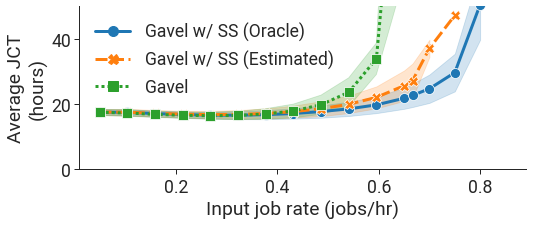

In [8]:
profiling_percentage = 0.2
print("V100s=4, P100s=4, K80s=4; Jobs 4000-5000")
print("profiling_percentage=%f" % profiling_percentage)
average_jcts = compute_metric(logfile_paths,
                              v100s=4, p100s=4, k80s=4,
                              policies=all_policies,
                              profiling_percentage=profiling_percentage,
                              num_reference_models=16,
                              seeds=all_seeds)
plot_input_job_rate_vs_average_jct(
    average_jcts,
    output_filename='throughput_estimation/profiling_percentage=0.20_v100=4_p100=4_k80=4.pdf')